# Markov State Modelling

The goal of `allostery` is to use MSMs to determine whether a binder is an allosteric modulator and affects protein activity. This means the MSMs have to be compared, which in turn requires that they are built in a comparable way. The `MSMCollection` class contains `MSM` objects (based on [pyemma](http://emma-project.org/latest/) modelling) and goes the process of building multiple models at the same time.

In [1]:
from allostery.msm import MSM, MSMCollection

/home/adele/Documents/allostery/allostery/msm/_msm.py:441: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/adele/anaconda3/envs/bss/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
/home/adele/Documents/allostery/allostery/msm/_msm.py:441: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/adele/Documents/allostery/allostery/msm/_msm.py:576: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_cluster

## Load data

The entry point to use `MSMCollection` is loading already featurized trajectory data. We have two examples provided in `example_data/`, a reference and data with a ligand called FRJ. The data files are called `rmsd_backbone_toclosed.txt` and `ptr_cys_dist.txt`, containing WPD loop RMSD and PTyr(P)-Cys215(S) distance respectively. The trajectory timestep in this case was 10 ps.

In [2]:
reference = ['example_data/reference/closed', 'example_data/reference/open']
frj = ['example_data/frj/closed', 'example_data/frj/open']

In [3]:
collection = MSMCollection()
collection.load_data(titles=['reference', 'FRJ'],
                     locations=[reference, frj],
                     file_names=['rmsd_backbone_toclosed.txt', 'ptr_cys_dist.txt'],
                     features=['RMSD/$\AA$', 'distance/$\AA$'],
                     missing='warn')

Loading data...
reference MSM
example_data/reference/closed
example_data/reference/open
trajectory 100/100
--------------------
FRJ MSM
example_data/frj/closed
example_data/frj/open
trajectory 100/100
--------------------
...done.


Note that the following loading of data requires a specific file structure, i.e. that each of the folders in `locations=` contains folders named `snapshot_[i]` which contains the featurized data files for that seeded MD run. Alternatively, the data can be loaded manually and assigned to the MSMs in the collection.

In [ ]:
manual = MSMCollection()
for msm in ['reference', 'FRJ']:
    manual.add_msm(msm)
    manual[msm].data = loaded_data

The `MSM` objects in `MSMCollection` can be accessed by using MSM titles as keys:

In [4]:
collection['reference']

Additionally all available MSMs can be accessed using `get_all()`:

In [5]:
collection.get_all()

{'reference': <allostery.msm._msm.MSM at 0x7fe4caa975b0>,
 'FRJ': <allostery.msm._msm.MSM at 0x7fe4cff9ab50>}

Plot data:

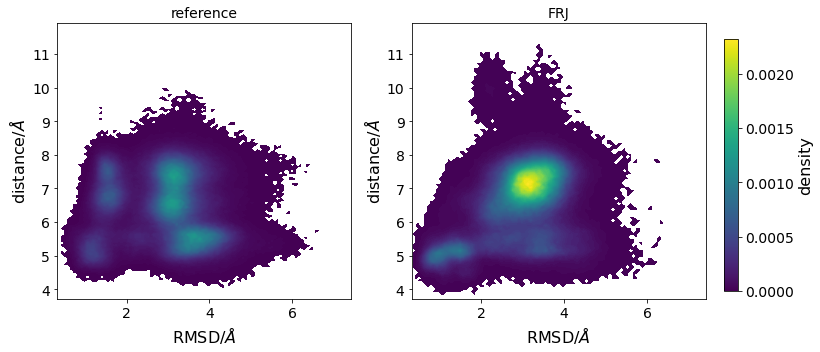

In [6]:
fig, ax, cbar = collection.plot_data((1,2))

## Clustering

The loaded data needs to be clustered to further discretize the conformational space. The same cluster centers will be used for all MSMs, and so all MSM data is pooled together for clustering. If `titles=` is specified in `MSMCollection.cluster()`, only those MSMs will be used for clustering.

In [7]:
collection.cluster()

20-10-22 12:15:23 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


Plot the clusters over data:

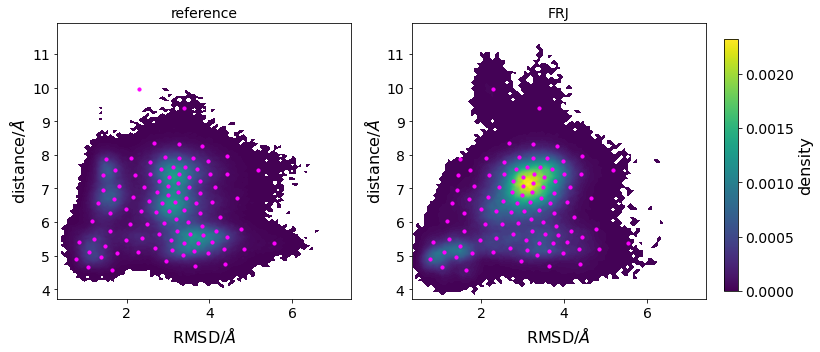

In [8]:
fig, ax, cbar = collection.plot_clusters([[collection.clusters.clustercenters]], (1,2))

The data for each MSM is then assigned to those cluster centers.

In [9]:
collection.assign_to_clusters()

## Implied timescales

Compute implied timescales to check for state separation and an appropriate lag time. If `titles=` specified, only those MSMs will have ITS computed.

Computing ITS...
reference
FRJ
...done.


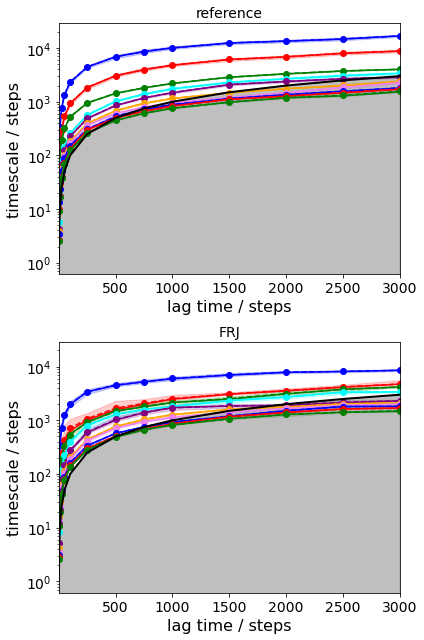

In [10]:
fig, ax = collection.compute_its()

## Build MSMs

Build the Markov State Models. Here a 20 ns lag time will be used.

In [11]:
collection.build_msms('20 ns')

Building MSMs...
...done.



The `pyemma.BayesianMSM` object is made accessible for any additional analysis:

In [12]:
collection['reference'].msm

BayesianMSM(conf=0.95, connectivity='largest', core_set=None,
      count_mode='effective', dt_traj='1 step', lag=2000,
      milestoning_method='last_core', mincount_connectivity='1/n',
      nsamples=100, nsteps=10, reversible=True, show_progress=False,
      sparse=False, statdist_constraint=None)

When MSMs are built using `pyemma`, the stationary distributions are computed for all connected sets:

In [13]:
collection['reference'].msm.stationary_distribution

array([0.00286512, 0.0177731 , 0.00857858, ..., 0.0068033 , 0.00596071,
       0.00782134])

However, when using data pooled together, some clusters may not be visited by some of the systems used for MSMs. `pyemma` discards those clusters and rearranged stationary distribution, as well as the cluster indices in `connected_sets`. Therefore the `MSM` object has its own `stationary_distribution` where the discarded clusters are inserted back as having probability of 0.

In [14]:
collection['reference'].stationary_distribution

array([0.00286512, 0.0177731 , 0.00857858, ..., 0.0068033 , 0.00596071,
       0.00782134])

## PCCA

In order to compare ligand effects on protein conformation distribution in a more meaningful way, the clusters are further assigned into metastable states using Perron Cluster-Cluster Analysis. Then the stationary probabilities for each metastable state are summed to give the probability of the system being in that state. `disconnected=` indicates which state the disconnected clusters are assigned to (since `pyemma` will not consider them during PCCA)

In [15]:
collection.pcca_assignments(2, 'reference')

Metastable state assignments based on reference MSM, 2 states:
reference
MS 1 has 22 counts and 22.2% probability (± 0.47%)
MS 2 has 78 counts and 77.8% probability (± 0.57%)
--------------------
FRJ
MS 1 has 22 counts and 5.22% probability (± 0.23%)
MS 2 has 78 counts and 94.78% probability (± 0.89%)
--------------------



Visualize the state assignments:

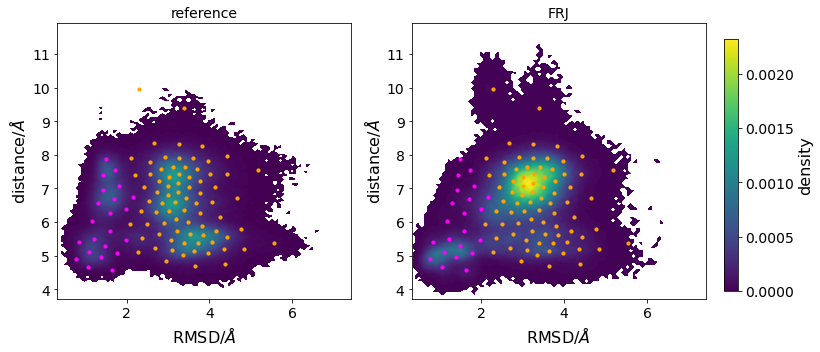

In [16]:
fig, ax, cbar = collection.plot_clusters(collection.get_pcca_clusters(2, ['reference']), (1,2))

The assignment values are available with the information of which PCCA was used for the metastable states. The numbers given are state probability, standard deviation and cluster count.

In [17]:
collection['reference'].metastable_assignments

{'reference, 2 states': {1: [22.2, 0.47, 22], 2: [77.8, 0.57, 78]}}

## Bootstrapping

One way to evaluate whether the trajectory data making up the MSM has sufficient sampling is to perform bootstrapping by resampling. A random n out of n trajectories are resampled out of available data (i.e. some will be sampled more than once) and the state probability is computed. Bootstrapping uses the same clusters and macrostate assignments (set by `n_states=` and `msm=` arguments) throughout, only the input data is different. This results in a distribution of probability values for each state.

Bootstrapping is performed until either `max_iter=` is reached, or until the resulting state probability distribution is converged to a Gaussian distribution. Convergence is defined as the last `last=` iterations not changing the distribution mean within a `tol=` tolerance. If the same number of iterations is more suitable, rather than checking for convergence, `min_iter=` can be set to be the same as `max_iter=`.

The below bootstrapping will use the metastable assignment from 2 state PCCA performed on the reference MSM to carry out bootstrapping on both MSMs in the collection, until the last 10 iterations have not changed the mean within 1%

In [18]:
bootstrapped_probabilities = collection.bootstrapping(n_states=2, msm='reference', verbose=True)

Bootstrapped probabilities, based on reference MSM, 2 states:
reference
State 1: 22.1% ± 7.59% (50 iterations)
State 2: 77.9% ± 7.59% (50 iterations)
------------------------------
FRJ
State 1: 5.68% ± 2.25% (22 iterations)
State 2: 94.32% ± 2.25% (22 iterations)
------------------------------


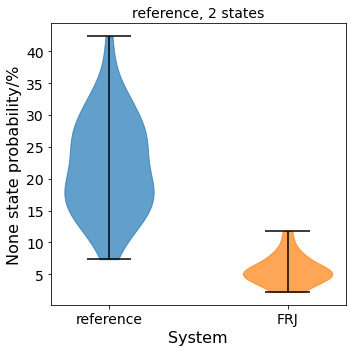

In [24]:
fig, ax = collection.plot_bootstrapping_violin(2, 1, 'reference')

The values are available as `metastable_assignments_bootstrapped`, as well as `bootstrapping_data` for any other analysis or plotting.

In [20]:
collection['reference'].metastable_assignments_bootstrapped

{'reference, 2 states': {1: [22.1, 7.59, 50], 2: [77.9, 7.59, 50]}}

In [21]:
collection['reference'].bootstrapping_data

{'reference, 2 states': {'probabilities': array([[11.25, 88.75],
         [28.93, 71.07],
         [16.64, 83.36],
         ...,
         [28.39, 71.61],
         [27.43, 72.57],
         [18.25, 81.75]]),
  'trajectories': [array([147, 164, 179, ..., 118, 140,  80]),
   array([110, 121, 159, ...,  61,  20, 135]),
   array([171,  61,  86, ..., 195,  96, 139]),
   array([117, 176, 118, ..., 187,  24, 130]),
   array([ 75, 180,  31, ..., 178, 192, 121]),
   array([ 77, 129, 183, ..., 186, 108, 174]),
   array([  9,  37, 177, ..., 195,  60, 144]),
   array([154, 106,  50, ...,  48,  58, 128]),
   array([ 71, 181,   4, ..., 192, 140, 185]),
   array([ 37,  50,  44, ..., 176, 127,  60]),
   array([124, 189, 108, ..., 187, 192,   2]),
   array([195,  16, 190, ..., 134,  59, 188]),
   array([ 99, 169, 134, ..., 102, 198, 175]),
   array([ 12, 105,  97, ..., 173, 123, 184]),
   array([165,   8,  41, ...,  32, 165,  33]),
   array([171,  67, 166, ..., 112,  24,  59]),
   array([157, 146,  78, .

## Saving the MSMs

The above can take a while, particularly the bootstrapping. The MSM collection can be saved and reloaded as follows:

In [22]:
collection.save('msm.pkl')

In [23]:
loaded_collection = MSMCollection('msm.pkl')

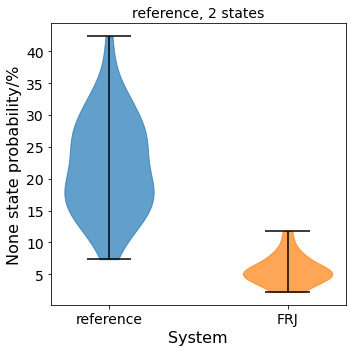

In [25]:
fig, ax = loaded_collection.plot_bootstrapping_violin(2, 1, 'reference')